<a href="https://colab.research.google.com/github/pazju/Chocolate-Ratings-Prediction/blob/main/Proyecto_Chocolate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYECTO INTELIGENCIA ARTIFICIAL - Juan Camilo Paz y Juan José Pinilla**

### **CHOCOLATE RATINGS PREDICTION**

## **1.**

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition # Modulo que incluye PCA y Kernel PCA 
from sklearn import datasets
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles, make_moons, make_classification
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score

from sklearn import svm

from numpy.lib.shape_base import column_stack
from sklearn import preprocessing


from sklearn.metrics import r2_score
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#from sklearn import *


# Compare Algorithms


from sklearn import model_selection

from sklearn.tree import DecisionTreeClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score


## **2.**

In [ ]:
#DATASET
dataset=pd.read_csv("chocolate_ratings.csv")


In [ ]:
#DATOS ANTES DE LA LIMPIEZA
dataset.head(3)

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75


In [ ]:
#LIMPIEZA DE DATOS
def clean(data):
  data = data.drop(["REF","Review Date", "Most Memorable Characteristics"], axis=1) #ELIMINACIÓN COLUMNAS  // POR EL MOMENTO BORRAMOS -> Most Memorable Characteristics (Calificar sentimiento es complejo)
  data = data.dropna() #ELIMINACIÓN FILAS CON DATOS NULOS
  cols = ["Cocoa Percent"]
   
  for col in cols:
    data[col] = pd.to_numeric(data[col].str.strip("%")) #PORCENTAJE A ENTERO
    data[col] = data[col]/100 #ENTERO A DECIMAL
  return data



dataclean=clean(dataset)
dataclean.head(10)




,Company (Manufacturer),Company Location,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Rating
0,5150,U.S.A.,Tanzania,"Kokoa Kamili, batch 1",0.76,"3- B,S,C",3.25
1,5150,U.S.A.,Dominican Republic,"Zorzal, batch 1",0.76,"3- B,S,C",3.50
2,5150,U.S.A.,Madagascar,"Bejofo Estate, batch 1",0.76,"3- B,S,C",3.75
3,5150,U.S.A.,Fiji,"Matasawalevu, batch 1",0.68,"3- B,S,C",3.00
4,5150,U.S.A.,Venezuela,"Sur del Lago, batch 1",0.72,"3- B,S,C",3.00
5,5150,U.S.A.,Uganda,"Semuliki Forest, batch 1",0.80,"3- B,S,C",3.25
6,5150,U.S.A.,India,"Anamalai, batch 1",0.68,"3- B,S,C",3.50
7,A. Morin,France,Bolivia,Bolivia,0.70,"4- B,S,C,L",3.50
8,A. Morin,France,Peru,Peru,0.63,"4- B,S,C,L",3.75
9,A. Morin,France,Panama,Panama,0.70,"4- B,S,C,L",2.75


In [ ]:
#CONVERTIR STRINGS A NÚMEROS
label_encoder = preprocessing.LabelEncoder()
cols2=["Company (Manufacturer)","Company Location", "Country of Bean Origin", "Specific Bean Origin or Bar Name", "Ingredients"]
for col in cols2:
  dataclean[col]=label_encoder.fit_transform(dataclean[col])
  #print(label_encoder.classes_)
dataclean.head(10)

,Company (Manufacturer),Company Location,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Rating
0,0,62,52,735,0.76,6,3.25
1,0,62,13,1560,0.76,6,3.50
2,0,62,28,159,0.76,6,3.75
3,0,62,16,914,0.68,6,3.00
4,0,62,60,1383,0.72,6,3.00
5,0,62,58,1330,0.80,6,3.25
6,0,62,23,83,0.68,6,3.50
7,1,18,3,202,0.70,13,3.50
8,1,18,36,1115,0.63,13,3.75
9,1,18,34,1092,0.70,13,2.75


In [ ]:
#CLASIFICAR EL RATING EN CLASES, DEFINIR RANGOS PARA FACILITAR LA CREACIÓN DE GRUPOS Y EL TRABAJO CON LOS DATOS

# Basado en código propuesto por Tetsuya Sasaki: https://www.kaggle.com/code/sasakitetsuya/feature-engineering-and-classification-model

# 4.0 - 5.0 = Outstanding='5'
# 3.5 - 3.9 = Highly Recommended='4'
# 3.0 - 3.4 = Recommended='3'
# 2.0 - 2.9 = Disappointing='2'
# 1.0 - 1.9 = Unpleasant='1'

def Rating_Rank(rating):
        if rating >= 4:
            return 5
        elif 3.5 <= rating <4:
            return 4
        elif 3.0 <= rating <3.5:
            return 3
        elif 2.0 <= rating <3.0:
            return 2
        else:
            return 1

dataclean.loc[:,'Rating_Rank']=dataclean.loc[:,'Rating'].apply(Rating_Rank) #Se puede cambiar la columna Rating por los nvos valores si se deja el mismo nombre, pero decidí dejarla
dataclean.head()


,Company (Manufacturer),Company Location,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Rating,Rating_Rank
0,0,62,52,735,0.76,6,3.25,3
1,0,62,13,1560,0.76,6,3.50,4
2,0,62,28,159,0.76,6,3.75,4
3,0,62,16,914,0.68,6,3.00,3
4,0,62,60,1383,0.72,6,3.00,3


In [ ]:
#Generar un archivo csv con los datos limpios.
dataclean.to_csv("Datos procesados.csv",index=False)

In [ ]:
#SEPARACIÓN CONJUNTO ENTRENAMIENTO, VALIDACIÓN Y PRUEBA (VER CLASE MARTES 3 DE MAYO - MIN 29)
#RECORDAR TEMA DE CROSS-VALIDATION

#SEPARACIÓN CONJUNTO ENTRENAMIENTO Y PRUEBA

y = dataclean['Rating_Rank'].values #Vamos a trabajar con los nuevos valores
X = dataclean[['Company (Manufacturer)','Company Location','Country of Bean Origin','Specific Bean Origin or Bar Name','Cocoa Percent','Ingredients']].values

#  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.1) 


# TRAINING Y TEST -> 90% ; VALIDATION -> 10%
# https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

# 70:10:20 for train:valid:test dataset
train_size=0.7

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7)

# Now since we want the valid and test size to be 10% and 20% 
# we have to define test_size=0.6 (that is 60% of remaining data)
test_size = 0.6
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.6)

In [ ]:
#ESCALIZACIÓN DE LOS DATOS (70% y 20%)
# Calcula la media y la desviación estandar del conjunto entrenado para escalizar todos los datos
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)  
X_valid = scaler.transform(X_valid)   #Escalizamos los de validación

## **NO CORRER PCA**

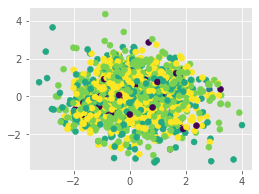

Pesos de PCA: [0.22309535 0.20027007 0.17386696 0.14934594 0.13078163 0.12264004]


In [ ]:
#PCA

#Preparar figura 2D
fig = plt.figure(2, figsize=(4, 3))
n=6

pca = decomposition.PCA(n_components=n)
pca.fit(X_train)
#PCA con 2 componentes al conjunto de características de entrenamiento y de validación
X_train = pca.transform(X_train)

y_train = np.choose(y_train, [1,2,3,4,5,0]).astype(float) # 1,2,3,4,5, 0
plt.scatter(X_train[:, 0], X_train[:, 1],  c=y_train,)

plt.show()
print("Pesos de PCA:",pca.explained_variance_ratio_)

In [ ]:
#conservar el 97%
print("Varianza explicada total de una reducción a N componentes principales: ", sum(pca.explained_variance_ratio_))

Varianza explicada total de una reducción a N componentes principales:  0.9999999999999999


Teniendo en cuenta el resultado anterior, NO se realiza PCA. Reducir su dimensionalidad NO cumple con el criterio del 97%. El último componente tiene un 12% reduciendo se obtendría un resultado menor a 97%.


shape of X_train (2198, 6)
[0.22284717 0.19879619 0.17504964 0.1461606  0.13304843 0.12409796]
sum: 1.0


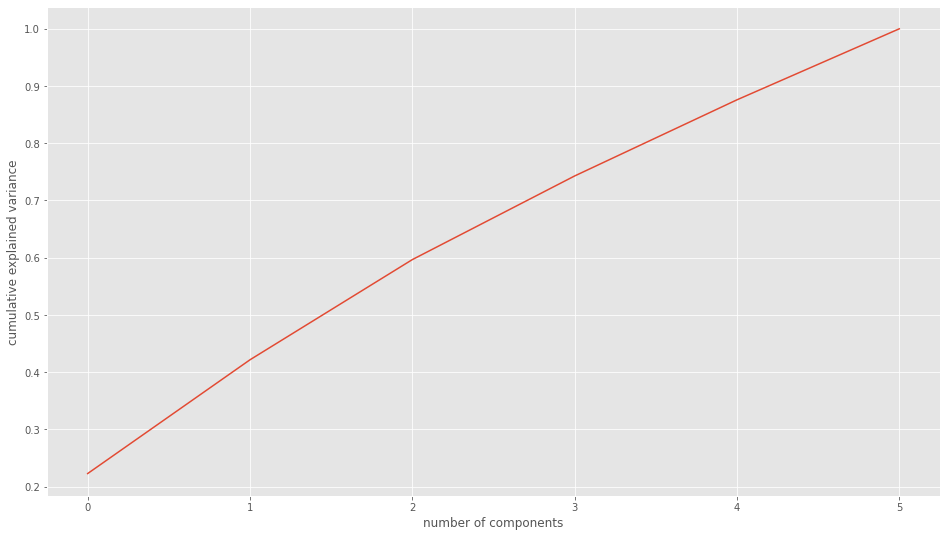

In [ ]:
#PCA con N componentes al conjunto de características de entrenamiento y de validación

print("shape of X_train", X_train.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('sum:',sum(expl[0:6]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

shape of X_test2 (245, 6)
[0.22284717 0.19879619 0.17504964 0.1461606  0.13304843 0.12409796]
sum: 1.0


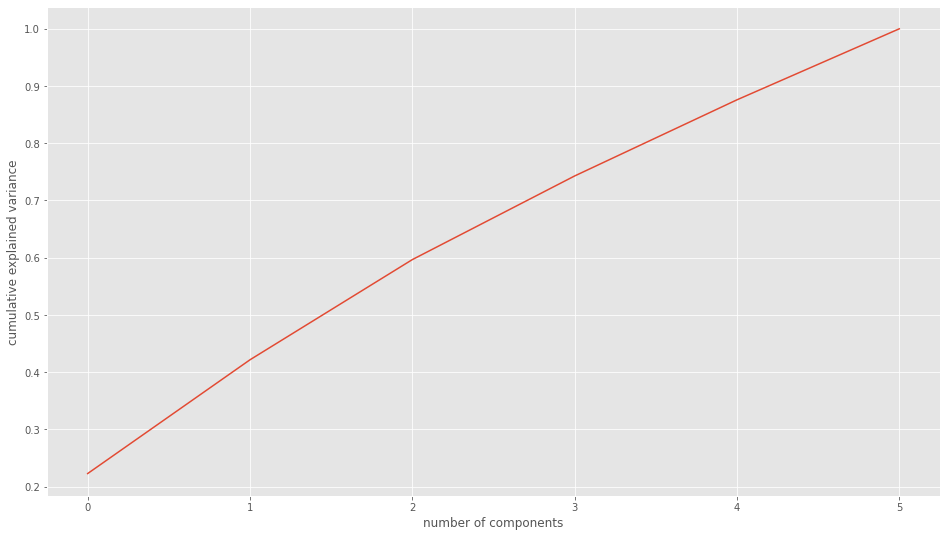

In [ ]:
print("shape of X_test2", X_test.shape)
expl1 = pca.explained_variance_ratio_
print(expl1)
print('sum:',sum(expl1[0:6]))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
#RECORDAR QUE SE DEBE HACER CROSS-VALIDATION ESE TEMA SE VIO EN UNA DE LAS ÚLTIMAS CLASES

In [ ]:
#Selección de métricas de evaluación 
# Coeficiente de determinación y una gráfica bien poderosa usando Seaborn por ejemplo (seaborn.regplot)

y =(X_train.shape)
f =(X_test.shape)
r2 = r2_score(y, f)
print('r2 score for a model which predicts mean value always is', r2)


r2 score for a model which predicts mean value always is -0.5876449364643828


[[0.00e+00 6.20e+01 5.20e+01 7.35e+02 7.60e-01 6.00e+00]
 [0.00e+00 6.20e+01 1.30e+01 1.56e+03 7.60e-01 6.00e+00]
 [0.00e+00 6.20e+01 2.80e+01 1.59e+02 7.60e-01 6.00e+00]
 ...
 [5.35e+02 3.00e+00 2.00e+00 4.79e+02 7.50e-01 6.00e+00]
 [5.35e+02 3.00e+00 9.00e+00 9.86e+02 7.00e-01 6.00e+00]
 [5.35e+02 3.00e+00 1.00e+00 9.31e+02 7.20e-01 6.00e+00]]
(2198, 6)


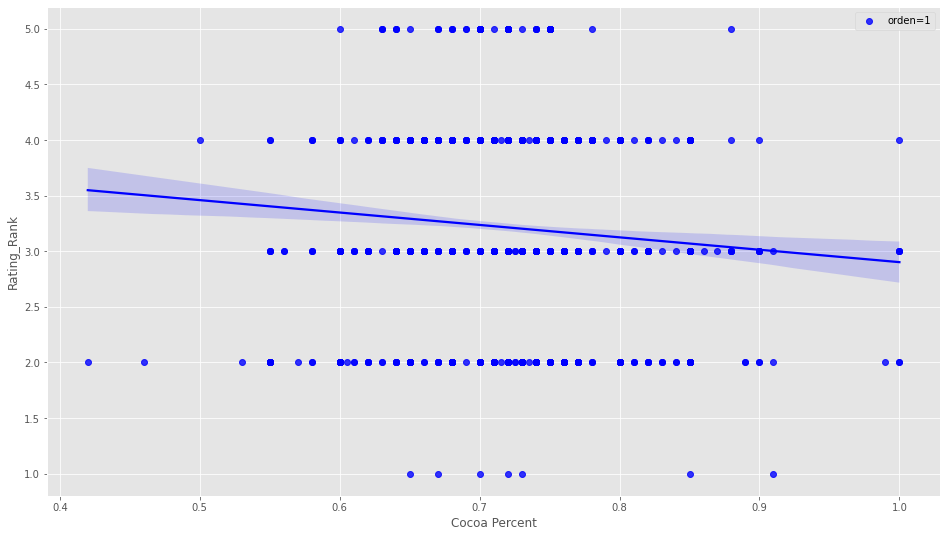

In [ ]:
sb.regplot(data=dataclean, y='Rating_Rank', x= 'Cocoa Percent', scatter=True,color='Blue',order=1,label="orden=1")
plt.legend(loc='upper right')
#print(X_train[1])
#print(X_test2[0])
print(X)
print(y)
#sb.regplot(dataclean, x=X_train[:,0], y= X_train[1], scatter=True,color='Blue',order=1,label="orden=1")
#plt.legend(loc='upper right')

# **KNN**

In [ ]:
# CROSS-VALIDATION Y OPTIMIZACIÓN DE HIPERPARAMETROS CON GRID SEARCH

grid = { 
    'n_neighbors': range(1,50),
    'weights' : ["uniform","distance"],
    'metric' : ["euclidean","manhattan","chebyshev","minkowski"],
    'algorithm' : ["auto", "ball_tree", "kd_tree", "brute"],
}


rf_cv = GridSearchCV(estimator= KNeighborsClassifier(), param_grid=grid, cv= 5)
rf_cv.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [ ]:
#Hiperparametros optimizados usando GridSearchCV
rf_cv.best_params_

{'algorithm': 'ball_tree',
 'metric': 'chebyshev',
 'n_neighbors': 43,
 'weights': 'uniform'}

In [ ]:
# MODELO OPTIMIZADO KNN
KNN = KNeighborsClassifier(n_neighbors =43,weights='uniform',metric='chebyshev', metric_params=None,algorithm='ball_tree')

KNN.fit(X_train, y_train)
y_test_predicted = KNN.predict(X_test)
y_test_scores = KNN.predict_proba(X_test)
MCC = r2_score(y_test, y_test_predicted)
print("R2 = ", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

R2 =  -0.47131927598432477
Accuracy 0.3477272727272727


## **REGRESIÓN LOGÍSTICA**


In [ ]:
# CROSS-VALIDATION Y OPTIMIZACIÓN DE HIPERPARAMETROS CON GRID SEARCH

grid = { 
   # 'penalty': ["l2","none"],
    'C' : np.arange(0.001,0.03,0.001),
    #'solver' : ["newton-cg", "lbfgs", "sag", "saga"],
}


rf_cv = GridSearchCV(estimator= LogisticRegression(), param_grid=grid, cv= 5)
rf_cv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029])})

In [ ]:
#Hiperparametros optimizados usando GridSearchCV
rf_cv.best_params_

{'C': 0.015}

In [ ]:
# MODELO OPTIMIZADO REGRESIÓN LOGÍSTICA
LR = LogisticRegression( max_iter=1000, C=0.015, random_state=0) #penalty='l2',, solver='newton-cg'

LR.fit(X_train, y_train)
y_test_predicted = LR.predict(X_test)
y_test_scores = LR.predict_proba(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("MCC = ", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

MCC =  0.043336783155627674
Accuracy 0.3931818181818182


COMPARACIÓN MODELOS


LR: 0.397661 (0.026283)
LDA: 0.400000 (0.027329)
KNN: 0.342105 (0.030750)
CART: 0.363743 (0.044751)
NB: 0.387135 (0.026645)
SVM: 0.388889 (0.040789)


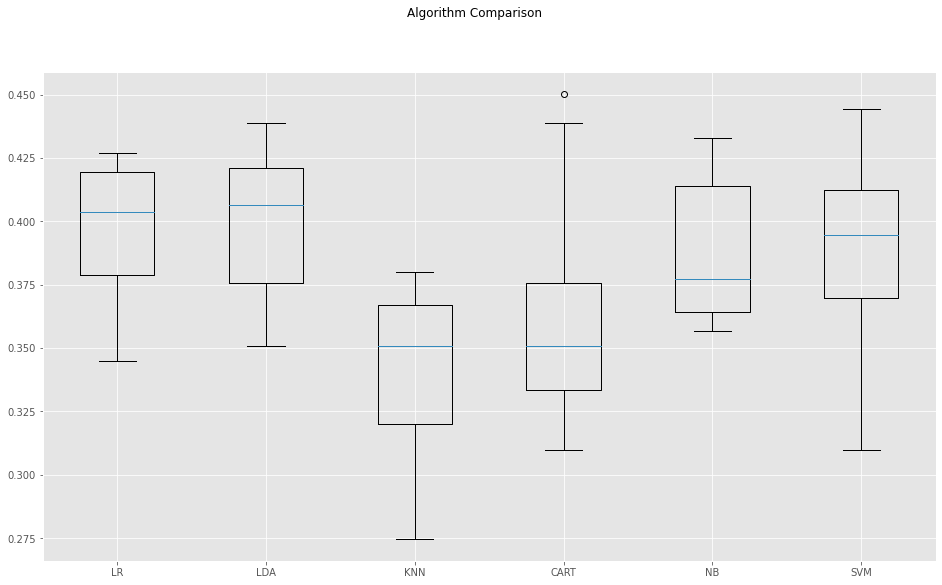

In [ ]:
#Gráfica comparación tomada
# prepare configuration for cross validation test harness
#seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy' #'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10) #, random_state=seed
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# **SVM**

In [ ]:
# CROSS-VALIDATION Y OPTIMIZACIÓN DE HIPERPARAMETROS CON GRID SEARCH

grid = { 
    'C' : [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel' : ['rbf'],
}


rf_cv = GridSearchCV(estimator= SVC(), param_grid=grid, cv= 5)
rf_cv.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [ ]:
#Hiperparametros optimizados usando GridSearchCV
rf_cv.best_params_


{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
# MODELO OPTIMIZADO
SVM = SVC( C=1000, kernel='rbf', gamma=0.001, shrinking=True,probability=True, random_state=None) 

SVM.fit(X_train, y_train)
y_test_predicted = SVM.predict(X_test)
y_test_scores = SVM.predict_proba(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("MCC = ", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

MCC =  0.00846477575405272
Accuracy 0.38636363636363635


# **Decision Tree**

In [ ]:
# CROSS-VALIDATION Y OPTIMIZACIÓN DE HIPERPARAMETROS CON GRID SEARCH

grid = { 
    'criterion' : ['gini','entropy'],
    'max_depth': range(1,10),
    'min_samples_split': range(1,10),
    'min_samples_leaf': range(1,5)
}


rf_cv = GridSearchCV(estimator= DecisionTreeClassifier(), param_grid=grid, cv= 5)
rf_cv.fit(X_train, y_train)


In [ ]:
#Hiperparametros optimizados usando GridSearchCV
rf_cv.best_params_


{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [ ]:
# MODELO OPTIMIZADO
Decision_tree = DecisionTreeClassifier( criterion='entropy', splitter='best', max_depth= 9, min_samples_split=4, min_samples_leaf=1,random_state=None,class_weight=None) 

Decision_tree.fit(X_train, y_train)
y_test_predicted = Decision_tree.predict(X_test)
y_test_scores = Decision_tree.predict_proba(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("MCC = ", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

MCC =  0.03865042855532814
Accuracy 0.3840909090909091


# **LDA**

In [ ]:
# CROSS-VALIDATION Y OPTIMIZACIÓN DE HIPERPARAMETROS CON GRID SEARCH

grid = { 
    'solver' : ['svd','lsqr','eigen']  
}


rf_cv = GridSearchCV(estimator= LinearDiscriminantAnalysis(), param_grid=grid, cv= 5)
rf_cv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'solver': ['svd', 'lsqr', 'eigen']})

In [ ]:
#Hiperparametros optimizados usando GridSearchCV
rf_cv.best_params_

{'solver': 'svd'}

## **3. MODELO OPTIMIZADO LDA, MEJOR OPCIÓN**

In [ ]:
# MODELO OPTIMIZADO
LDA = LinearDiscriminantAnalysis( solver= 'svd',shrinkage=None,priors=None,n_components=None,store_covariance=False) 

LDA.fit(X_train, y_train)
y_test_predicted = LDA.predict(X_test)
y_test_scores = LDA.predict_proba(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("MCC = ", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

MCC =  0.04914373462848003
Accuracy 0.425


## **4. RE-ENTRENAMIENTO LDA**

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
x_retrain = scaler.transform(X)

LDA = LinearDiscriminantAnalysis( solver= 'svd',shrinkage=None,priors=None,n_components=None,store_covariance=False) 


LDA.fit(x_retrain, y)
y_test_predicted = LDA.predict(X_test)
y_test_scores =LDA.predict_proba(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("MCC = ", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy = ", ACC)
F1_macro = f1_score(y_test, y_test_predicted, average='macro')
print("F1_macro = ", F1_macro)
F1_weighted = f1_score(y_test, y_test_predicted, average='weighted')
print("F1_weighted = ", F1_weighted)


MCC =  0.12884037401854784
Accuracy =  0.4681818181818182
F1_macro =  0.2588423996020105
F1_weighted =  0.4038324888533318
